# Random Forest Model

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
    f1_score,
    roc_curve
)
import joblib
import warnings
warnings.filterwarnings('ignore')


In [7]:

X_train = pd.read_csv("X_train_standard.csv")
X_test  = pd.read_csv("X_test_standard.csv")
y_train = pd.read_csv("y_train.csv").squeeze()
y_test  = pd.read_csv("y_test.csv").squeeze()


In [8]:

X_combined = pd.concat([X_train, X_test], axis=0)
X_combined_dummies = pd.get_dummies(X_combined, drop_first=True)

X_train_dummies = X_combined_dummies.iloc[:len(X_train), :]
X_test_dummies = X_combined_dummies.iloc[len(X_train):, :]
X_test_dummies = X_test_dummies.reindex(columns=X_train_dummies.columns, fill_value=0)


## Porównanie metod balansu klasy

In [9]:

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_dummies, y_train)

rf_smote = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42, class_weight="balanced")
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_rf_smote = rf_smote.predict(X_test_dummies)
y_prob_rf_smote = rf_smote.predict_proba(X_test_dummies)[:, 1]

print("=== Random Forest z SMOTE ===")
print(classification_report(y_test, y_pred_rf_smote))
print("AUC:", roc_auc_score(y_test, y_prob_rf_smote).round(4))


=== Random Forest z SMOTE ===
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     19553
           1       0.38      0.61      0.47      3408

    accuracy                           0.79     22961
   macro avg       0.65      0.72      0.67     22961
weighted avg       0.84      0.79      0.81     22961

AUC: 0.821


In [10]:

rf_weight = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42, class_weight="balanced")
rf_weight.fit(X_train_dummies, y_train)
y_pred_rf_weight = rf_weight.predict(X_test_dummies)
y_prob_rf_weight = rf_weight.predict_proba(X_test_dummies)[:, 1]

print("=== Random Forest tylko z class_weight ===")
print(classification_report(y_test, y_pred_rf_weight))
print("AUC:", roc_auc_score(y_test, y_prob_rf_weight).round(4))


=== Random Forest tylko z class_weight ===
              precision    recall  f1-score   support

           0       0.95      0.73      0.82     19553
           1       0.33      0.77      0.46      3408

    accuracy                           0.73     22961
   macro avg       0.64      0.75      0.64     22961
weighted avg       0.86      0.73      0.77     22961

AUC: 0.832


## Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [4, 6],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.0, 0.001],
    'max_leaf_nodes': [None, 30]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_dummies, y_train)
print("Best params:", grid.best_params_)
print("Best AUC:", grid.best_score_)


Fitting 3 folds for each of 384 candidates, totalling 1152 fits
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best AUC: 0.8423823689499869


In [12]:

rf_model = grid.best_estimator_
y_prob_rf = rf_model.predict_proba(X_test_dummies)[:, 1]
y_pred_rf = rf_model.predict(X_test_dummies)

print("=== Random Forest – model końcowy ===")
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_prob_rf))


=== Random Forest – model końcowy ===
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     19553
           1       0.33      0.77      0.46      3408

    accuracy                           0.73     22961
   macro avg       0.64      0.75      0.64     22961
weighted avg       0.86      0.73      0.77     22961

AUC: 0.8322575735529458


In [13]:

gini = 2 * roc_auc_score(y_test, y_prob_rf) - 1
print(f"Gini: {gini:.4f}")


Gini: 0.6645


## Kalibracja progu decyzyjnego

In [14]:

thresholds = np.arange(0.1, 0.9, 0.05)
for t in thresholds:
    y_pred_t = (y_prob_rf >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    f1 = f1_score(y_test, y_pred_t)
    print(f"Threshold={t:.2f} → F1={f1:.3f}, TPR={tpr:.3f}, FPR={fpr:.3f}")


Threshold=0.10 → F1=0.262, TPR=1.000, FPR=0.984
Threshold=0.15 → F1=0.289, TPR=0.998, FPR=0.857
Threshold=0.20 → F1=0.308, TPR=0.997, FPR=0.781
Threshold=0.25 → F1=0.331, TPR=0.989, FPR=0.695
Threshold=0.30 → F1=0.364, TPR=0.969, FPR=0.586
Threshold=0.35 → F1=0.395, TPR=0.939, FPR=0.491
Threshold=0.40 → F1=0.420, TPR=0.897, FPR=0.414
Threshold=0.45 → F1=0.440, TPR=0.858, FPR=0.356
Threshold=0.50 → F1=0.460, TPR=0.775, FPR=0.277
Threshold=0.55 → F1=0.479, TPR=0.671, FPR=0.197
Threshold=0.60 → F1=0.475, TPR=0.540, FPR=0.128
Threshold=0.65 → F1=0.447, TPR=0.421, FPR=0.080
Threshold=0.70 → F1=0.402, TPR=0.320, FPR=0.048
Threshold=0.75 → F1=0.325, TPR=0.226, FPR=0.028
Threshold=0.80 → F1=0.225, TPR=0.137, FPR=0.013
Threshold=0.85 → F1=0.104, TPR=0.056, FPR=0.004


In [15]:
y_pred_proba = rf_model.predict_proba(X_test_dummies)[:, 1]
y_pred_thresh = (y_pred_proba >= 0.55).astype(int)

print("=== Final Classification Report @ 0.55 ===")
print(classification_report(y_test, y_pred_thresh))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_thresh))

roc_auc = roc_auc_score(y_test, y_pred_proba)
gini = 2 * roc_auc - 1
print(f"AUC: {roc_auc:.2f}")
print(f"Gini: {gini:.2f}")


=== Final Classification Report @ 0.55 ===
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     19553
           1       0.37      0.67      0.48      3408

    accuracy                           0.78     22961
   macro avg       0.65      0.74      0.67     22961
weighted avg       0.85      0.78      0.81     22961

Confusion Matrix:
[[15706  3847]
 [ 1122  2286]]
AUC: 0.83
Gini: 0.66


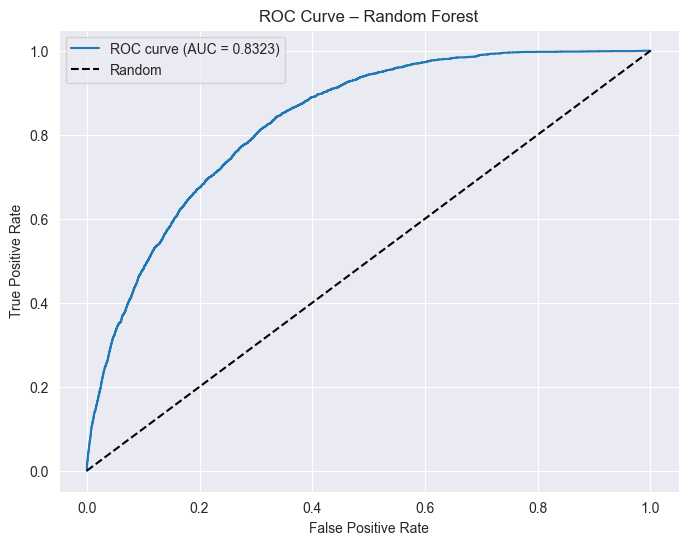

In [16]:

fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_prob_rf):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Random Forest')
plt.legend()
plt.grid(True)
plt.show()


In [17]:

joblib.dump(rf_model, "random_forest.pkl")
print("Model zapisany jako random_forest.pkl")


Model zapisany jako random_forest.pkl
